# ÎáåÏ¢ÖÏñë Î∂ÑÎ•ò

## Îç∞Ïù¥ÌÑ∞ ÏÖã Î∂àÎü¨Ïò§Í∏∞
- ÍµêÎ™® ÏÑ∏Ìè¨Ï¢Ö
- ÏàòÎßâÏ¢Ö
- Ï¢ÖÏñë ÏóÜÏùå
- ÎáåÌïòÏàòÏ≤¥ Ï¢ÖÏñë

In [1]:
root = './datasets/brain/original/'

In [2]:
from glob import glob
import os

directories = glob(os.path.join(root, '*'))
directory_names = []
for directory in directories:
    directory_names.append(directory[directory.rindex('\\') + 1:])

print(directory_names)

['glioma', 'meningioma', 'notumor', 'pituitary']


In [3]:
for name in directory_names:
    for i, file_name in enumerate(os.listdir(os.path.join(root, name))):
        old_file = os.path.join(root + name + '/', file_name)
        new_file = os.path.join(root + name + '/', name + str(i + 1) + '.png')

        os.rename(old_file, new_file)

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 32

image_generator = ImageDataGenerator(rescale = 1./255)

generator = image_generator.flow_from_directory(root, target_size=(244,244), batch_size=BATCH_SIZE, class_mode='categorical')
print(generator.class_indices)

Found 5712 images belonging to 4 classes.
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [5]:
target_name = {v: k for k, v in generator.class_indices.items()}
target_name

{0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}

In [6]:
target_names = []
for target in generator.classes:
    target_names.append(target_name[target])

In [7]:
import pandas as pd

brain_df = pd.DataFrame({'file_paths': generator.filepaths, 'target_names': target_names, 'targets': generator.classes})
brain_df.file_paths = brain_df.file_paths.apply(lambda file_path: file_path.replace('\\', '/'))
brain_df

file_paths target_names  targets
0          ./datasets/brain/original/glioma/glioma1.png       glioma        0
1         ./datasets/brain/original/glioma/glioma10.png       glioma        0
2        ./datasets/brain/original/glioma/glioma100.png       glioma        0
3       ./datasets/brain/original/glioma/glioma1000.png       glioma        0
4       ./datasets/brain/original/glioma/glioma1001.png       glioma        0
...                                                 ...          ...      ...
5707  ./datasets/brain/original/pituitary/pituitary9...    pituitary        3
5708  ./datasets/brain/original/pituitary/pituitary9...    pituitary        3
5709  ./datasets/brain/original/pituitary/pituitary9...    pituitary        3
5710  ./datasets/brain/original/pituitary/pituitary9...    pituitary        3
5711  ./datasets/brain/original/pituitary/pituitary9...    pituitary        3

[5712 rows x 3 columns]

In [8]:
from sklearn.model_selection import train_test_split

train_images,test_images, train_targets, test_targets = \
train_test_split(brain_df.file_paths, 
                 brain_df.targets, 
                 stratify=brain_df.targets, 
                 test_size=0.2, random_state=124)

print(train_targets.value_counts())
print(test_targets.value_counts())

targets
2    1276
3    1165
1    1071
0    1057
Name: count, dtype: int64
targets
2    319
3    292
1    268
0    264
Name: count, dtype: int64


In [9]:
from sklearn.model_selection import train_test_split

train_images, validation_images, train_targets, validation_targets = \
train_test_split(train_images, 
                 train_targets, 
                 stratify=train_targets, 
                 test_size=0.2, random_state=124)

print(train_targets.value_counts())
print(validation_targets.value_counts())

targets
2    1021
3     932
1     857
0     845
Name: count, dtype: int64
targets
2    255
3    233
1    214
0    212
Name: count, dtype: int64


In [11]:
train_df = brain_df.iloc[train_images.index].reset_index(drop=True)
validation_df = brain_df.iloc[validation_images.index].reset_index(drop=True)
test_df = brain_df.iloc[test_images.index].reset_index(drop=True)
print(train_df.shape)
print(validation_df.shape)
print(test_df.shape)

(3655, 3)
(914, 3)
(1143, 3)


## ÏÉòÌîå Îç∞Ïù¥ÌÑ∞

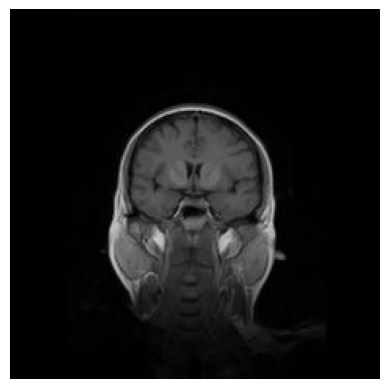

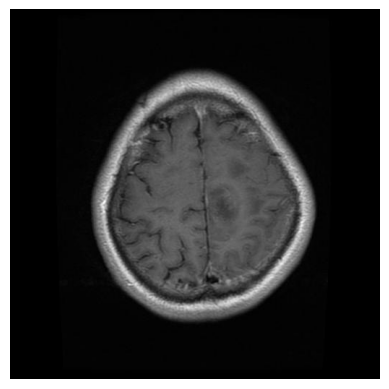

In [12]:
import cv2
import matplotlib.pyplot as plt

image = cv2.cvtColor(cv2.imread(train_df.file_paths.iloc[500]), cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis('off')
plt.show()

image = cv2.cvtColor(cv2.imread(train_df.file_paths.iloc[100]), cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis('off')
plt.show()

### Ïù¥ÎØ∏ÏßÄÏôÄ Î∞∞ÏπòÏÇ¨Ïù¥Ï¶à

In [13]:
IMAGE_SIZE = 128
BATCH_SIZE = 32

### 1Ô∏è‚É£ Ï†ÅÏ†àÌïú ÏÇ¨Ï†ÑÎ™®Îç∏ Ï∞æÍ∏∞

In [14]:
import numpy as np
from tensorflow.keras.utils import Sequence
from sklearn.utils import shuffle
import cv2

# Îç∞Ïù¥ÌÑ∞ ÏÑ∏Ìä∏ ÏÉùÏÑ± class Ï†ïÏùò
class Dataset(Sequence):
    # ÌÅ¥ÎûòÏä§Ïùò Ï¥àÍ∏∞Ìôî
    # Í≤ΩÎ°ú, ÌÉÄÍ≤ü, Î∞∞Ïπò ÌÅ¨Í∏∞, albumentations Í∞ùÏ≤¥, Ï†ÑÏ≤òÎ¶¨ ÌïòÎßà, ÏÖîÌîå Ïó¨Î∂ÄÎ•º Ïù∏ÏûêÎ°ú Î∞õÏùå
    def __init__(self, file_paths, targets, batch_size=BATCH_SIZE, aug=None, preprocess=None, shuffle=False):
        self.file_paths = file_paths
        self.targets = targets
        self.batch_size = batch_size
        self.aug = aug
        self.preprocess = preprocess
        self.shuffle = shuffle

        # shuffle True Ïãú ÏßÑÌñâ:
        if self.shuffle:
            # epoch ÎÅùÎÇ† ÎïåÎßàÎã§ Ìò∏Ï∂ú
            self.on_epoch_end()

    # Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ ÏÑ∏Ìä∏ ÌÅ¨Í∏∞ Î∞òÌôò
    def __len__(self):
        # ÌïòÎÇòÏùò Î∞∞Ïπò ÏÇ¨Ïù¥Ï¶àÏóê ÌïÑÏöîÌïú Îç∞Ïù¥ÌÑ∞ Í∞úÏàò Î¶¨ÌÑ¥
        return int(np.ceil(len(self.targets) / self.batch_size))

    # Ï£ºÏñ¥ÏßÑ Ïù∏Îç±Ïä§Ïóê Ìï¥ÎãπÌïòÎäî Î∞∞Ïπò Î∞òÌôò
    def __getitem__(self, index):
        # ÌååÏùº Í≤ΩÎ°úÏôÄ ÌÉÄÍ≤ü Îç∞Ïù¥ÌÑ∞Î•º Î∞∞Ïπò ÌÅ¨Í∏∞ÎßåÌÅº ÏûêÎ•¥Í≥†, Ïù¥ÎØ∏ÏßÄÎ•º Î∂àÎü¨ÏôÄ Ï≤òÎ¶¨Ìïú ÌõÑ Î∞∞ÏπòÎ°ú Î∞òÌôò
        file_paths_batch = self.file_paths[index * self.batch_size: (index + 1) * self.batch_size]
        targets_batch = self.targets[index * self.batch_size: (index + 1) * self.batch_size]

        # Îç∞Ïù¥ÌÑ∞ Î∞∞Ïπò Ï†ÄÏû•
        results_batch = np.zeros((file_paths_batch.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

        # Îç∞Ïù¥ÌÑ∞ ÏàòÎßåÌÅº Î∞òÎ≥µ
        for i in range(file_paths_batch.shape[0]):
            # RGBÎ°ú ÏÉâÏÉÅ ÌòïÏãùÏùÑ Î≥ÄÌôòÌïòÏó¨ Ïù¥ÎØ∏ÏßÄ Í∞ÄÏ†∏Ïò§Í∏∞
            image = cv2.cvtColor(cv2.imread(file_paths_batch[i]), cv2.COLOR_BGR2RGB)
            # Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞ Ï°∞Ï†ï
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

            # albumentationsÏù¥ ÏûàÎã§Î©¥:
            if self.aug is not None:
                # Augmentor Í∞ùÏ≤¥Î°ú Ïù¥ÎØ∏ÏßÄ Î≥ÄÌôò
                image = self.aug(image=image)['image']

            # Ï†ÑÏ≤òÎ¶¨ Ìï®ÏàòÍ∞Ä ÏûàÎã§Î©¥:
            if self.preprocess is not None:
                # Ïù¥ÎØ∏ÏßÄ Ï†ÑÏ≤òÎ¶¨ ÏßÑÌñâ
                image = self.preprocess(image)

            # Í≤∞Í≥º Î∞∞ÏπòÏóê Ïù¥ÎØ∏ÏßÄÎ•º Ï†ÄÏû•
            results_batch[i] = image

        # Í≤∞Í≥º Î∞∞ÏπòÏôÄ ÌÉÄÍ≤ü Î∞∞ÏπòÎ•º Î∞òÌôò
        return results_batch, targets_batch
        
    def on_epoch_end(self):
        # shuffle ÏòµÏÖòÏù¥ ÏºúÏ†∏ÏûàÎã§Î©¥, Îç∞Ïù¥ÌÑ∞Î•º ÏÑûÍ∏∞
        if self.shuffle:
            # epoch ÎÅùÎÇ† ÎïåÎßàÎã§ Îç∞Ïù¥ÌÑ∞ ÏÑûÍ∏∞
            self.file_paths, self.targets = shuffle(self.file_paths, self.targets)

In [15]:
def create_dataset(paths, targets, BATCH_SIZE, shuffle=True):   
    return Dataset(paths,
                   targets,
                   batch_size=BATCH_SIZE,
                   shuffle=True)

In [16]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt

from tensorflow.keras.applications.vgg16 import VGG16, decode_predictions as vgg16_decode_predictions
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, decode_predictions as resnet50v2_decode_predictions
from tensorflow.keras.applications.xception import Xception, decode_predictions as xception_decode_predictions
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, decode_predictions as mobilenetv2_decode_predictions

def predict_and_display(images, titles, model_name):
    figure, axs = plt.subplots(figsize=(22, 4), nrows=1, ncols=len(images))

    # VGG16 Î™®Îç∏ ÏÑ†ÌÉù
    if model_name == 'vgg16':
        model = VGG16()
        decode_predictions = vgg16_decode_predictions
        target_size = (224, 224)
    # ResNet50V2 Î™®Îç∏ ÏÑ†ÌÉù
    elif model_name == 'resnet50': # ResNet50, 74.9% ; ResNet50V2, 76.0%
        model = ResNet50V2()
        decode_predictions = resnet50v2_decode_predictions
        target_size = (224, 224)
    # Xception Î™®Îç∏ ÏÑ†ÌÉù
    elif model_name == 'xception': # InceptionÏùÑ Í∏∞Ï¥àÎ°ú Ìïú Î™®Îç∏
        model = Xception()
        decode_predictions = xception_decode_predictions
        target_size = (299, 299)
    # MobileNetV2 Î™®Îç∏ ÏÑ†ÌÉù
    elif model_name == 'mobilenet':
        model = MobileNetV2()
        decode_predictions = mobilenetv2_decode_predictions
        target_size = (224, 224)

    for i, image in enumerate(images):
        # Î™®Îç∏ ÏûÖÎ†• ÌÅ¨Í∏∞Ïóê ÎßûÍ≤å Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞ Ï°∞Ï†ï
        resized_image = cv2.resize(image, target_size)
        # Ïù¥ÎØ∏ÏßÄ Î∞∞Ïó¥Î°ú Î≥ÄÌôò
        image_array = img_to_array(resized_image)
        # Ï∞®Ïõê ÌôïÏû• (Î∞∞Ïó¥Ïùò Ï≤´ Î≤àÏß∏ Ï∞®Ïõê ÌôïÏû•)
        image_array = np.expand_dims(image_array, axis=0)
        # Ïù¥ÎØ∏ÏßÄ ÏòàÏ∏°
        prediction = model.predict(image_array)
        # Ïù¥ÎØ∏ÏßÄ Î∂ÑÎ•ò Î™®Îç∏Ïùò ÏòàÏ∏° Í≤∞Í≥ºÎ•º Ìï¥ÏÑù
        target = decode_predictions(prediction)
        # ÎÜíÏùÄ ÌôïÎ•†Î°ú ÏòàÏ∏° Îêú ÌÅ¥ÎûòÏä§ Ïù¥Î¶ÑÍ≥º ÌôïÎ•†
        predicted_class = target[0][0][1]
        predicted_probability = np.round(target[0][0][2] * 100, 2)
        
        # Ïù¥ÎØ∏ÏßÄÏôÄ ÏòàÏ∏° Í≤∞Í≥º ÌëúÏãú
        axs[i].imshow(image.astype('int'))
        axs[i].axis('off')
        axs[i].set_title(f"{predicted_class}\n{predicted_probability}%")

        print(target)

In [17]:
import matplotlib.pyplot as plt

def show_images(files_batch, ncols=4, title=None):    
    figure, axs = plt.subplots(figsize=(22, 4), nrows=1, ncols=ncols)
    
    for i in range(ncols):
        # files_batchÎäî floatÏù¥ÎØÄÎ°ú intÎ°ú Î≥ÄÍ≤Ω
        axs[i].imshow(np.array(files_batch[i], dtype='int32'))
        axs[i].axis('off')
        axs[i].set_title(title[i]) 

In [18]:
import albumentations as A

# Í∞Å ÌÅ¥ÎûòÏä§ÏóêÏÑú ÌïòÎÇòÏî© Ïù¥ÎØ∏ÏßÄÎ•º ÏÉòÌîåÎßÅÌïòÏó¨ Í∑†Îì±Ìïú Î∞∞Ïπò Íµ¨ÏÑ±
sampled_df = test_df.groupby('targets', group_keys=False).apply(lambda x: x.sample(1))

# Îç∞Ïù¥ÌÑ∞ Í≤ΩÎ°ú Î∞è ÌÉÄÍ≤ü Îã¥Í∏∞ (get_dummiesÎ•º ÌÜµÌï¥ Ïõê-Ìï´ Ïù∏ÏΩîÎî© ÏßÑÌñâ)
sampled_file_paths = sampled_df['file_paths'].values
sampled_targets = pd.get_dummies(sampled_df['targets']).values # CategoricalCrossEntropy


In [19]:
dataset = create_dataset(sampled_file_paths, sampled_targets, BATCH_SIZE, shuffle=True)

In [20]:
files_batch, targets_batch = next(iter(dataset))
# Î†àÏù¥Î∏î Ïù∏ÏΩîÎî©Ïãú, target Ï∞®ÏõêÏùÑ 2Ï∞®ÏõêÏúºÎ°ú ÎßûÏ∂∞Ï§òÏïº ÌïúÎã§.
print(files_batch.shape, targets_batch.shape)

(4, 128, 128, 3) (4, 4)


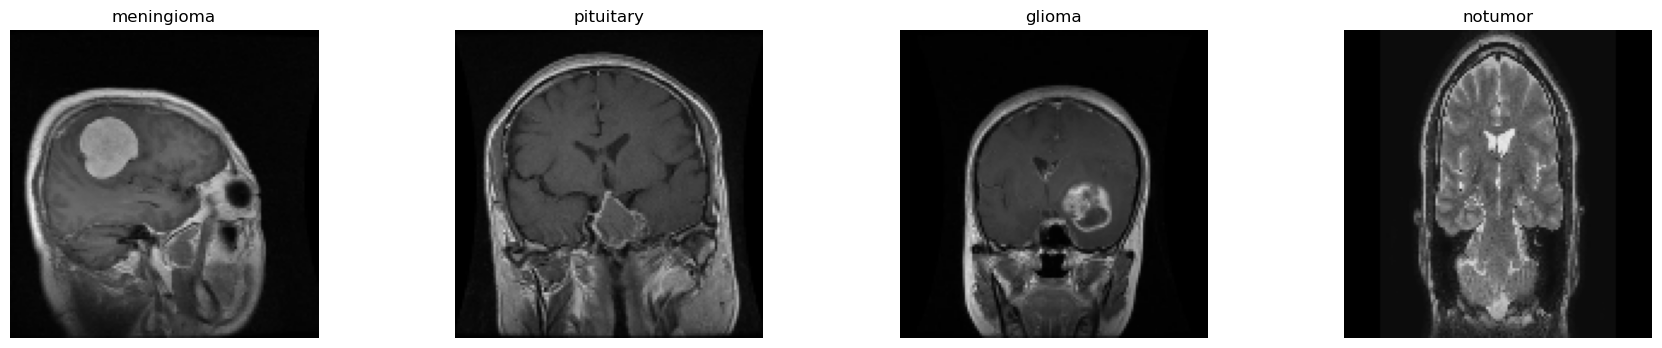

In [22]:
# Ïù¥ÎØ∏ÏßÄ Ï†úÎ™© ÏÉùÏÑ±
titles = [target_name[np.argmax(target)] for target in targets_batch]

# Ï†ïÎãµ Ï∂úÎ†•
show_images(files_batch, ncols=4, title=titles)

vgg16
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 592ms/step
[[('n01930112', 'nematode', 0.20440061), ('n04127249', 'safety_pin', 0.13507222), ('n02910353', 'buckle', 0.05080406), ('n03532672', 'hook', 0.043914486), ('n04423845', 'thimble', 0.03730225)]]
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 322ms/step
[[('n04026417', 'purse', 0.15229835), ('n03950228', 'pitcher', 0.1195009), ('n04423845', 'thimble', 0.0947506), ('n02948072', 'candle', 0.092557386), ('n03916031', 'perfume', 0.05560336)]]
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 238ms/step
[[('n03443371', 'goblet', 0.35724396), ('n03916031', 'perfume', 0.10211849), ('n09229709', 'bubble', 0.09629617), ('n04127249', 'safety_pin', 0.043046564), ('n04522168', 'vase', 0.032410637)]]
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 201ms/step
[[('n01930112', 'nematode', 0.67903894), ('n02869837', 'bonnet', 0.016905822), ('n03584829', 'iron', 0

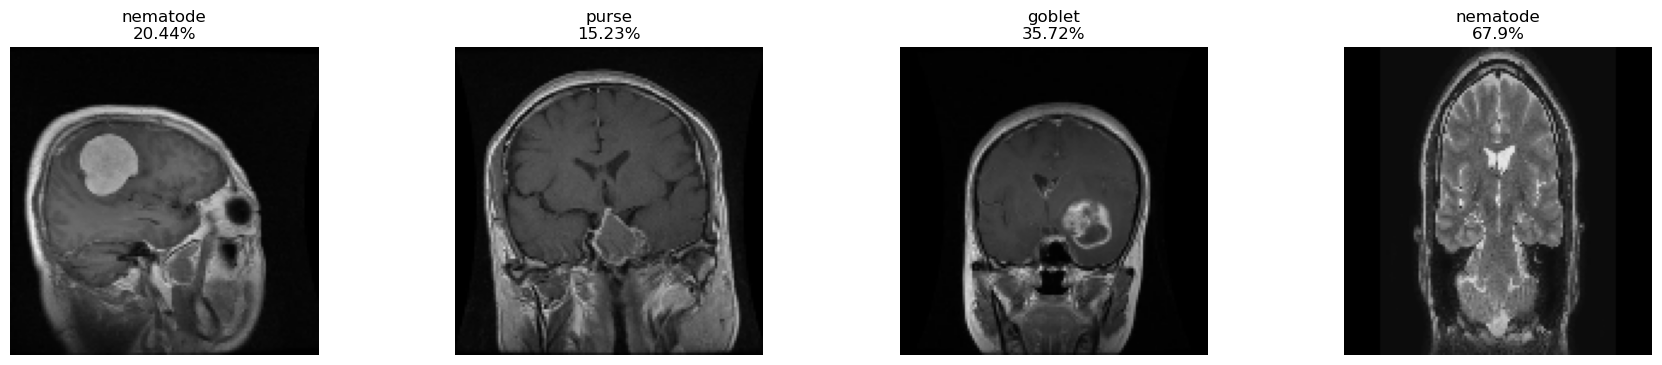

In [23]:
# ÏòàÏ∏° Î™®Îç∏ Ï∂úÎ†•
print('vgg16')
predict_and_display(files_batch, titles, 'vgg16')

xception
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2s/step
[[('n03942813', 'ping-pong_ball', 0.33941182), ('n03131574', 'crib', 0.25890133), ('n03775546', 'mixing_bowl', 0.22695859), ('n02971356', 'carton', 0.11521989), ('n02769748', 'backpack', 0.030539202)]]
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 112ms/step
[[('n02971356', 'carton', 0.40448585), ('n03131574', 'crib', 0.39161214), ('n03942813', 'ping-pong_ball', 0.095709845), ('n03908618', 'pencil_box', 0.055619802), ('n03775546', 'mixing_bowl', 0.023156172)]]
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 236ms/step
[[('n03942813', 'ping-pong_ball', 0.767249), ('n03825788', 'nipple', 0.15448791), ('n03594945', 'jeep', 0.022574132), ('n03937543', 'pill_bottle', 0.020763526), ('n02115641', 'dingo', 0.012769149)]]
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 94ms/step
[[('n03825788', 'nipple', 0.43606362), ('n03131574', 'crib', 0.429857), 

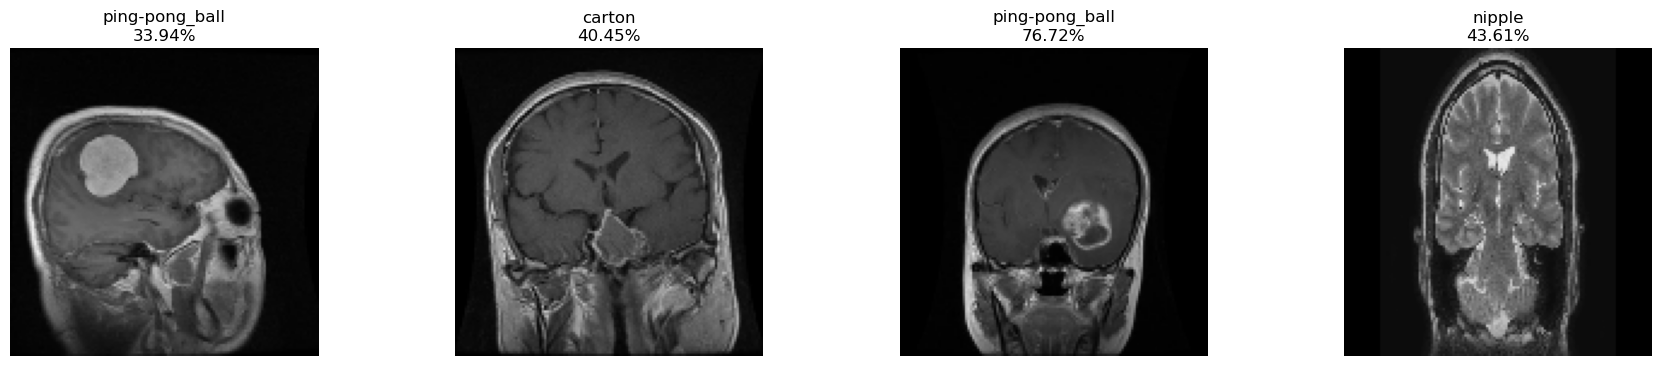

In [24]:
# ÏòàÏ∏° Î™®Îç∏ Ï∂úÎ†•
print('xception')
predict_and_display(files_batch, titles, 'xception')

resnet50
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2s/step
[[('n07613480', 'trifle', 1.0), ('n02356798', 'fox_squirrel', 3.0411373e-24), ('n02089973', 'English_foxhound', 3.0463693e-27), ('n02795169', 'barrel', 1.4079008e-27), ('n02085782', 'Japanese_spaniel', 5.7961543e-30)]]
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 219ms/step
[[('n07613480', 'trifle', 1.0), ('n02089973', 'English_foxhound', 2.2307656e-16), ('n02356798', 'fox_squirrel', 5.25709e-28), ('n07871810', 'meat_loaf', 1.8417758e-36), ('n02490219', 'marmoset', 8.6139683e-38)]]
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 148ms/step
[[('n07613480', 'trifle', 1.0), ('n02089973', 'English_foxhound', 4.530963e-12), ('n02085782', 'Japanese_spaniel', 1.5208351e-12), ('n02795169', 'barrel', 7.32517e-18), ('n02356798', 'fox_squirrel', 4.337305e-18)]]
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 211ms/step
[[('n07613480', 'trifle', 1.0), 

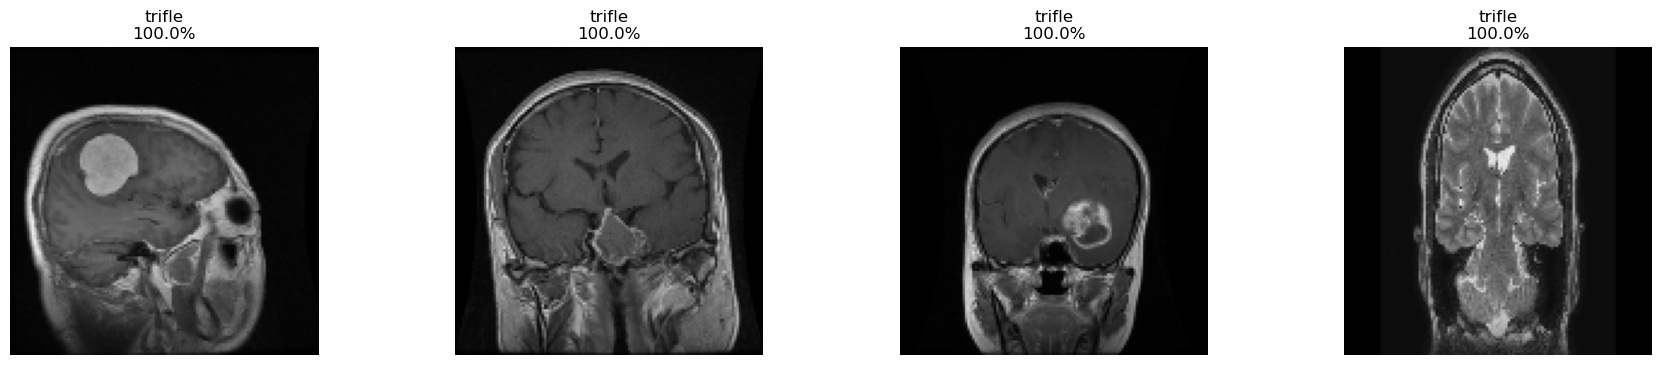

In [25]:
# ÏòàÏ∏° Î™®Îç∏ Ï∂úÎ†•
print('resnet50')
predict_and_display(files_batch, titles, 'resnet50')

mobilenet
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 1s/step
[[('n03938244', 'pillow', 0.96264654), ('n03485794', 'handkerchief', 0.008736875), ('n03733281', 'maze', 0.0038765124), ('n04591157', 'Windsor_tie', 0.0022513773), ('n02834397', 'bib', 0.0022064992)]]
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 25ms/step
[[('n03938244', 'pillow', 0.99666154), ('n03485794', 'handkerchief', 0.0018901312), ('n04591157', 'Windsor_tie', 0.0003921512), ('n02834397', 'bib', 0.00020660541), ('n03871628', 'packet', 4.9322698e-05)]]
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 49ms/step
[[('n03938244', 'pillow', 0.95160896), ('n04591157', 'Windsor_tie', 0.0070839105), ('n03485794', 'handkerchief', 0.0025592258), ('n02895154', 'breastplate', 0.0024266096), ('n03871628', 'packet', 0.0023803874)]]
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 239ms/step
[[('n03637318', 'lampshade', 0.16876534), ('n04286575', 'spo

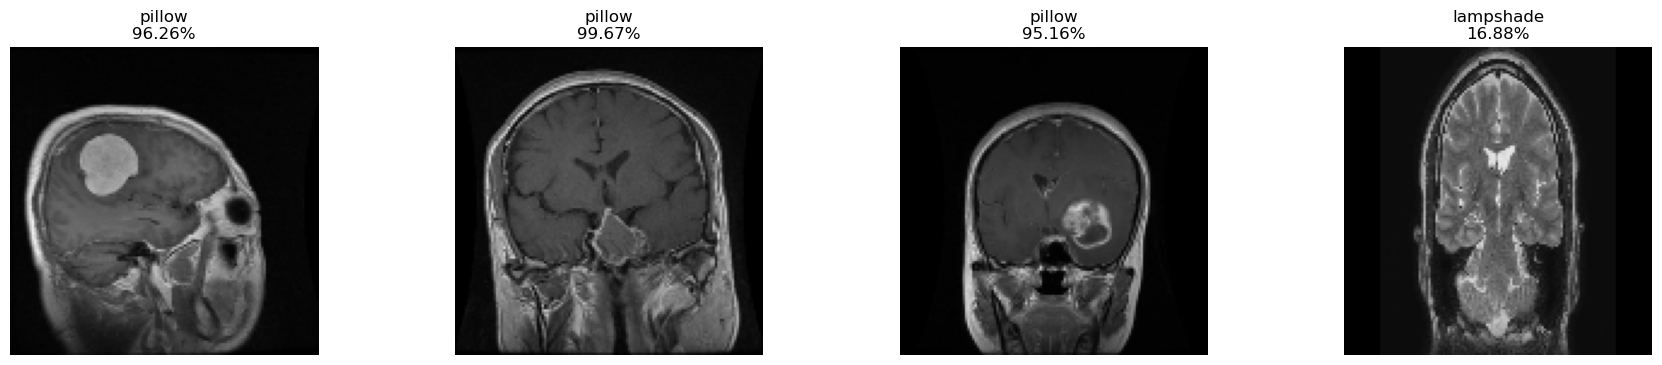

In [26]:
# ÏòàÏ∏° Î™®Îç∏ Ï∂úÎ†•
print('mobilenet')
predict_and_display(files_batch, titles, 'mobilenet')

### 2Ô∏è‚É£ Vgg16Ïù¥ ÌöåÏ∂©ÏùÑ ÏòàÏ∏°ÌïòÏó¨ Vgg16ÏùÑ Ï±ÑÌÉù

- Îã§Îßå Ïú†ÏÇ¨ÏÑ±Ïù¥ ÎÜíÎã§Í≥† ÌåêÎã®ÎêòÏßÄÎäî ÏïäÏïÑ ÏµúÏÉÅÏúÑ Í≥ÑÏ∏µÎßå freezeÌïú ÌõÑ ÌïôÏäµ ÏãúÌÇ§Îäî Î∞©ÏãùÏúºÎ°ú ÏßÑÌñâ

In [27]:
from tensorflow.keras.applications.resnet50 import preprocess_input

train_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

train_flow = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_paths',
    y_col='target_names',
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = "categorical",
    shuffle=True
)

validation_flow = validation_generator.flow_from_dataframe(
    dataframe=validation_df,
    x_col='file_paths',
    y_col='target_names',
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = "categorical"
)

test_flow = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_paths',
    y_col='target_names',
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = "categorical"
)
print(train_flow.class_indices)
print(validation_flow.class_indices)
print(test_flow.class_indices)

Found 3655 validated image filenames belonging to 4 classes.
Found 914 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [28]:
import numpy as np
from tensorflow.keras.utils import Sequence
from sklearn.utils import shuffle
import cv2

class Dataset(Sequence):
    def __init__(self, file_paths, targets, batch_size=BATCH_SIZE, aug=None, preprocess=None, shuffle=False):
        self.file_paths = file_paths
        self.targets = targets
        self.batch_size = batch_size
        self.aug = aug
        self.preprocess = preprocess
        self.shuffle = shuffle

        if self.shuffle:
            self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.targets) / self.batch_size))

    # batch_size Îã®ÏúÑÎ°ú Ïù¥ÎØ∏ÏßÄ Î∞∞Ïó¥Í≥º ÌÉÄÏºì Îç∞Ïù¥ÌÑ∞Îì§ÏùÑ Í∞ÄÏ†∏Ïò® Îí§ Î≥ÄÌôòÌïú Í∞íÏùÑ Î¶¨ÌÑ¥ÌïúÎã§.
    def __getitem__(self, index):
        file_paths_batch = self.file_paths[index * self.batch_size: (index + 1) * self.batch_size]
        targets_batch = self.targets[index * self.batch_size: (index + 1) * self.batch_size]

        results_batch = np.zeros((file_paths_batch.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

        for i in range(file_paths_batch.shape[0]):
            image = cv2.cvtColor(cv2.imread(file_paths_batch[i]), cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

            if self.aug is not None:
                image = self.aug(image=image)['image']

            if self.preprocess is not None:
                image = self.preprocess(image)
                    
            results_batch[i] = image

        return results_batch, targets_batch
        
    def on_epoch_end(self):
        if self.shuffle:
            self.file_paths, self.targets = shuffle(self.file_paths, self.targets)        

In [29]:
import albumentations as A
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input

train_file_paths = train_df['file_paths'].values
train_targets = pd.get_dummies(train_df['targets']).values

validation_file_paths = validation_df['file_paths'].values
validation_targets = pd.get_dummies(validation_df['targets']).values

test_file_paths = test_df['file_paths'].values
test_targets = pd.get_dummies(test_df['targets']).values


train_dataset = Dataset(train_file_paths, 
                        train_targets, 
                        batch_size=BATCH_SIZE, 
                        preprocess=vgg16_preprocess_input, 
                        shuffle=True)

validation_dataset = Dataset(validation_file_paths, 
                        validation_targets, 
                        batch_size=BATCH_SIZE, 
                        preprocess=vgg16_preprocess_input)

test_dataset = Dataset(test_file_paths, 
                        test_targets, 
                        batch_size=BATCH_SIZE, 
                        preprocess=vgg16_preprocess_input)

In [31]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2

def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50': # ResNet50, 74.9% ; ResNet50V2, 76.0%
        model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception': # InceptionÏùÑ Í∏∞Ï¥àÎ°ú Ìïú Î™®Îç∏
        model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobilenet':
        model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')

    x = model.output

    # Î∂ÑÎ•òÍ∏∞
    x = GlobalAveragePooling2D()(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu')(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    output = Dense(4, activation='softmax', name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
    
    return model

In [32]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# weights Ï†ÄÏû•
mcp_cb = ModelCheckpoint(
    filepath="./callback_files/1cycle/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=True,
    mode='min'
)

# ÏùºÏ†ï Í∏∞Í∞Ñ ÎèôÏïà ÏÑ±Îä•Ïù¥ Í∞úÏÑ†ÎêòÏßÄ ÏïäÏùÑ Ïãú ÌïôÏäµÎ•† ÎèôÏ†ÅÏúºÎ°ú Í∞êÏÜå
rlr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    mode='min'
)

# ÏùºÏ†ï Í∏∞Í∞Ñ ÎèôÏïà ÏÑ±Îä•Ïù¥ Í∞úÏÑ†ÎêòÏßÄ ÏïäÏùÑ Ïãú ÌïôÏäµ Ï°∞Í∏∞ Ï§ëÎã®
ely_cb = EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)

In [33]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy

model = create_model(model_name='vgg16', verbose=True)
model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['acc'])

Model: "functional_1"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                         ‚îÉ Output Shape                ‚îÉ         Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer_4 (InputLayer)           ‚îÇ (None, 128, 128, 3)         ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block1_conv1 (Conv2D)                ‚îÇ (None, 128, 128, 64)        ‚îÇ           1,792 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block1_conv2 (Conv2D)                ‚îÇ (None, 128, 128, 64)        ‚îÇ          36,928 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block1_pool (MaxPooling2D)           ‚îÇ (None, 64, 64, 64)          ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block2_conv1 (Conv2D)                ‚îÇ (None, 64, 64, 128)         ‚îÇ          73,856 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block2_conv2 (Conv2D)                ‚îÇ (None, 64, 64, 128)         ‚îÇ         147,584 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block2_pool (MaxPooling2D)           ‚îÇ (None, 32, 32, 128)         ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block3_conv1 (Conv2D)                ‚îÇ (None, 32, 32, 256)         ‚îÇ         295,168 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block3_conv2 (Conv2D)                ‚îÇ (None, 32, 32, 256)         ‚îÇ         590,080 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block3_conv3 (Conv2D)                ‚îÇ (None, 32, 32, 256)         ‚îÇ         590,080 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

 Total params: 14,740,542 (56.23 MB)

 Trainable params: 14,740,542 (56.23 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
import gc

# Î©îÎ™®Î¶¨ Ìï¥Ï†ú Ìï®Ïàò
gc.collect()

98898

In [35]:
# Î∞òÎ≥µÌöüÏàò ÏßÄÏ†ï
# ÎåÄÎ¨∏ÏûêÎ°ú ÏÉÅÏàòÎ•º ÌëúÍ∏∞ÌïòÎ©¥ Îã§Î•∏ Î∂ÄÎ∂ÑÏóêÏÑú Î≥ÄÍ≤ΩÎêòÏßÄ ÏïäÎäîÎã§Îäî Í≤ÉÏùÑ ÏùòÎØ∏
N_EPOCHS = 10

# ÌõàÎ†®
history = model.fit(train_dataset,
                    batch_size=BATCH_SIZE,
                    epochs=N_EPOCHS, 
                    validation_data=validation_dataset,
                    callbacks=[mcp_cb, rlr_cb, ely_cb])

Epoch 1/10


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


115/115 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 310s 3s/step - acc: 0.2575 - loss: 8.9568 - val_acc: 0.2790 - val_loss: 1.3418 - learning_rate: 0.0010
Epoch 2/10
115/115 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 313s 3s/step - acc: 0.3388 - loss: 1.2707 - val_acc: 0.5886 - val_loss: 0.9674 - learning_rate: 0.0010
Epoch 3/10
115/115 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 311s 3s/step - acc: 0.6292 - loss: 0.8580 - val_acc: 0.7079 - val_loss: 0.7716 - learning_rate: 0.0010
Epoch 4/10
115/115 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 312s 3s/step - acc: 0.7147 - loss: 0.7079 - val_acc: 0.7735 - val_loss: 0.6194 - learning_rate: 0.0010
Epoch 5/10
115/115 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 318s 3s/step - acc: 0.7466 - loss: 0.6190 - val_acc: 0.7670 - val_loss: 0.6452 - learning_rate: 0.0010
Epoch 6/10
115/115 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 327s 3s/step - a

In [46]:
test_file_paths = test_df['file_paths'].values
test_targets = pd.get_dummies(test_df['targets']).values

test_dataset = Dataset(test_file_paths, 
                            test_targets, 
                            batch_size=BATCH_SIZE, 
                            preprocess=resnet50_preprocess_input)

model.evaluate(test_dataset, batch_size=BATCH_SIZE)

36/36 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 26s 716ms/step - acc: 0.8712 - loss: 0.3351


[0.3110418915748596, 0.8836395740509033]

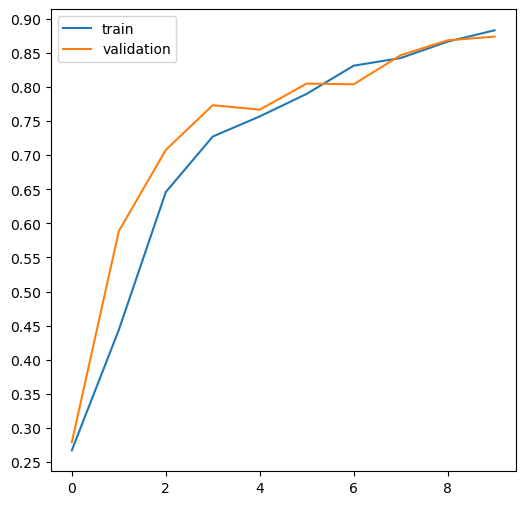

In [47]:
import matplotlib.pyplot as plt

def show_history(history):
    plt.figure(figsize=(6, 6))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='validation')
    plt.legend()
    
show_history(history)

### üö© Í≤∞Í≥º

#### ÌïôÏäµ Í≤∞Í≥º
- acc: 0.8812
- loss: 0.3271
- val_acc: 0.8742
- val_loss: 0.3445

#### ÏòàÏÉÅ Í≤∞Í≥º
- acc: 0.8712
- loss: 0.3351

### Í≥ºÏ†ÅÌï©Ïù¥ ÏóÜÍ≥†, Ï†ïÌïôÎèÑÍ∞Ä 8.8Ï†ïÎèÑÎ°ú Ï†ÅÌï©ÌïòÎã§Í≥† ÏÉùÍ∞ÅÌïòÏó¨ fine tuningÏùÑ ÏßÑÌñâ

### 3Ô∏è‚É£ ÎØ∏ÏÑ∏Ï°∞Ï†ï

In [36]:
# freeze ÌôïÏù∏ÌïòÍ∏∞
for i, layer in enumerate(model.layers[:-5]):
    layer.trainable = False
    print(i + 1, '.', layer.name, 'trainable:', layer.trainable)

print('\n######### classifier layers ######### ')
for layer in model.layers[-5:]:
    print(layer.name, 'trainable:', layer.trainable)

1 . input_layer_4 trainable: False
2 . block1_conv1 trainable: False
3 . block1_conv2 trainable: False
4 . block1_pool trainable: False
5 . block2_conv1 trainable: False
6 . block2_conv2 trainable: False
7 . block2_pool trainable: False
8 . block3_conv1 trainable: False
9 . block3_conv2 trainable: False
10 . block3_conv3 trainable: False
11 . block3_pool trainable: False
12 . block4_conv1 trainable: False
13 . block4_conv2 trainable: False
14 . block4_conv3 trainable: False
15 . block4_pool trainable: False
16 . block5_conv1 trainable: False
17 . block5_conv2 trainable: False

######### classifier layers ######### 
block5_conv3 trainable: True
block5_pool trainable: True
global_average_pooling2d_1 trainable: True
dense trainable: True
output trainable: True


In [59]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras import layers

def fine_tune(datas, model_name, aug, preprocess):
    FIRST_EPOCHS = 10
    SECOND_EPOCHS = 10
    
    train_file_paths, train_targets, \
    validation_file_paths, validation_targets, \
    test_file_paths, test_targets = datas

    train_dataset = Dataset(train_file_paths, 
                        train_targets, 
                        batch_size=BATCH_SIZE, 
                        aug=aug, 
                        preprocess=preprocess, 
                        shuffle=True)

    validation_dataset = Dataset(validation_file_paths, 
                            validation_targets, 
                            batch_size=BATCH_SIZE, 
                            preprocess=preprocess)
    
    model = create_model(model_name=model_name, verbose=True)
    model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['acc'])

    # feature extractor layerÎì§ÏùÑ Ï†ÑÎ∂Ä freeze
    for layer in model.layers[:-5]:
        layer.trainable = False

    model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=FIRST_EPOCHS, 
              validation_data=validation_dataset)

    # Î∞∞Ïπò Ï†ïÍ∑úÌôîÎßå freeze ÏßÑÌñâ
    for layer in model.layers:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

        # Î∂ÄÎ∂Ñ freeze ÏßÑÌñâ
    for layer in model.layers[:8]:
        layer.trainable = False
        
    model.compile(optimizer=Adam(0.00001), loss=BinaryCrossentropy(), metrics=['acc'])
    history = model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=SECOND_EPOCHS, 
              validation_data=validation_dataset)
    
    return model, history

In [43]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
import albumentations as A

train_file_paths = train_df['file_paths'].values
train_targets = pd.get_dummies(train_df['targets']).values

validation_file_paths = validation_df['file_paths'].values
validation_targets = pd.get_dummies(validation_df['targets']).values

aug = A.Compose([
    A.ShiftScaleRotate(p=0.5),
    A.HorizontalFlip(p=0.5),
],p=0.3)

model1, history1 = fine_tune((train_file_paths, train_targets,
           validation_file_paths, validation_targets,
           test_file_paths, test_targets),
          'vgg16', 
          aug,
          vgg16_preprocess_input)

Model: "functional_11"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                         ‚îÉ Output Shape                ‚îÉ         Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer_9 (InputLayer)           ‚îÇ (None, 128, 128, 3)         ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block1_conv1 (Conv2D)                ‚îÇ (None, 128, 128, 64)        ‚îÇ           1,792 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block1_conv2 (Conv2D)                ‚îÇ (None, 128, 128, 64)        ‚îÇ          36,928 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block1_pool (MaxPooling2D)           ‚îÇ (None, 64, 64, 64)          ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block2_conv1 (Conv2D)                ‚îÇ (None, 64, 64, 128)         ‚îÇ          73,856 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block2_conv2 (Conv2D)                ‚îÇ (None, 64, 64, 128)         ‚îÇ         147,584 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block2_pool (MaxPooling2D)           ‚îÇ (None, 32, 32, 128)         ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block3_conv1 (Conv2D)                ‚îÇ (None, 32, 32, 256)         ‚îÇ         295,168 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block3_conv2 (Conv2D)                ‚îÇ (None, 32, 32, 256)         ‚îÇ         590,080 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block3_conv3 (Conv2D)                ‚îÇ (None, 32, 32, 256)         ‚îÇ         590,080 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

 Total params: 14,740,542 (56.23 MB)

 Trainable params: 14,740,542 (56.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
115/115 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 119s 1s/step - acc: 0.6377 - loss: 1.5763 - val_acc: 0.8993 - val_loss: 0.1547
Epoch 2/10
115/115 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 108s 934ms/step - acc: 0.8879 - loss: 0.1819 - val_acc: 0.8895 - val_loss: 0.1654
Epoch 3/10
115/115 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 114s 981ms/step - acc: 0.9098 - loss: 0.1258 - val_acc: 0.9245 - val_loss: 0.1218
Epoch 4/10
115/115 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 111s 955ms/step - acc: 0.9427 - loss: 0.0880 - val_acc: 0.9278 - val_loss: 0.1160
Epoch 5/10
115/115 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 118s 1s/step - acc: 0.9501 - loss: 0.0770 - val_acc: 0.9136 - val_loss: 0.1264
Epoch 6/10
115/115 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 118s 1s/step - acc: 0.9513 - loss: 0.0776 - val_acc: 0.9409 - val_loss: 0.0994
Epoch 7/10
115/115 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

In [44]:
test_file_paths = test_df['file_paths'].values
test_targets = pd.get_dummies(test_df['targets']).values

test_dataset = Dataset(test_file_paths, 
                            test_targets, 
                            batch_size=BATCH_SIZE, 
                            preprocess=resnet50_preprocess_input)

model1.evaluate(test_dataset, batch_size=BATCH_SIZE)

36/36 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 26s 725ms/step - acc: 0.9645 - loss: 0.0652


[0.06409920752048492, 0.9693788290023804]

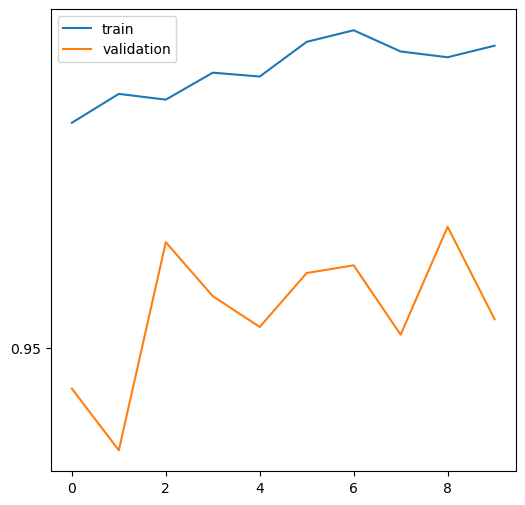

In [45]:
import matplotlib.pyplot as plt

def show_history(history):
    plt.figure(figsize=(6, 6))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='validation')
    plt.legend()
    
show_history(history1)

### 

#### Î∂ÑÎ•òÍ∏∞Ï†úÏô∏ freezeÌïú Frist epoch
- acc: 0.9834
- loss: 0.0328
- val_acc: 0.9245
- val_loss: 0.1411

#### Î∞∞Ïπò Ï†ïÍ∑úÌôîÏôÄ ÏµúÏÉÅÏúÑÎ•º freezeÌïú second epoch
- acc: 0.9956
- loss: 0.0089
- val_acc: 0.9540
- val_loss: 0.1037

#### Î∂ÑÎ•òÍ∏∞Îßå Ï†úÏô∏ÌïòÍ≥† freezeÎ•º ÏßÑÌñâÌïú Í≤∞Í≥º, ÏãúÍ∞ÑÏù¥ Î∞òÏúºÎ°úÏ§ÑÏñ¥Îì†Îç∞Ïóê Î∞òÌï¥ ÏÑ±Îä•ÏùÑ Ïú†ÏßÄ
#### ÌïòÏßÄÎßå ÏµúÏÉÅÏúÑÎßå freezeÌïòÍ≥† ÌïôÏäµÏùÑ ÏßÑÌñâÌïú Í≤∞Í≥º ÏãúÍ∞ÑÏù¥ Ïù¥Ï†ÑÍ≥º ÎèôÏùº
#### ÏÑ±Îä• ÌèâÍ∞Ä ÏßÑÌñâ

### 4Ô∏è‚É£ ÏÑ±Îä•ÌèâÍ∞Ä

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 59ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 60ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 53ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 64ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 44ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 52ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 52ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 48ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 52ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 53ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 53ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 51ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

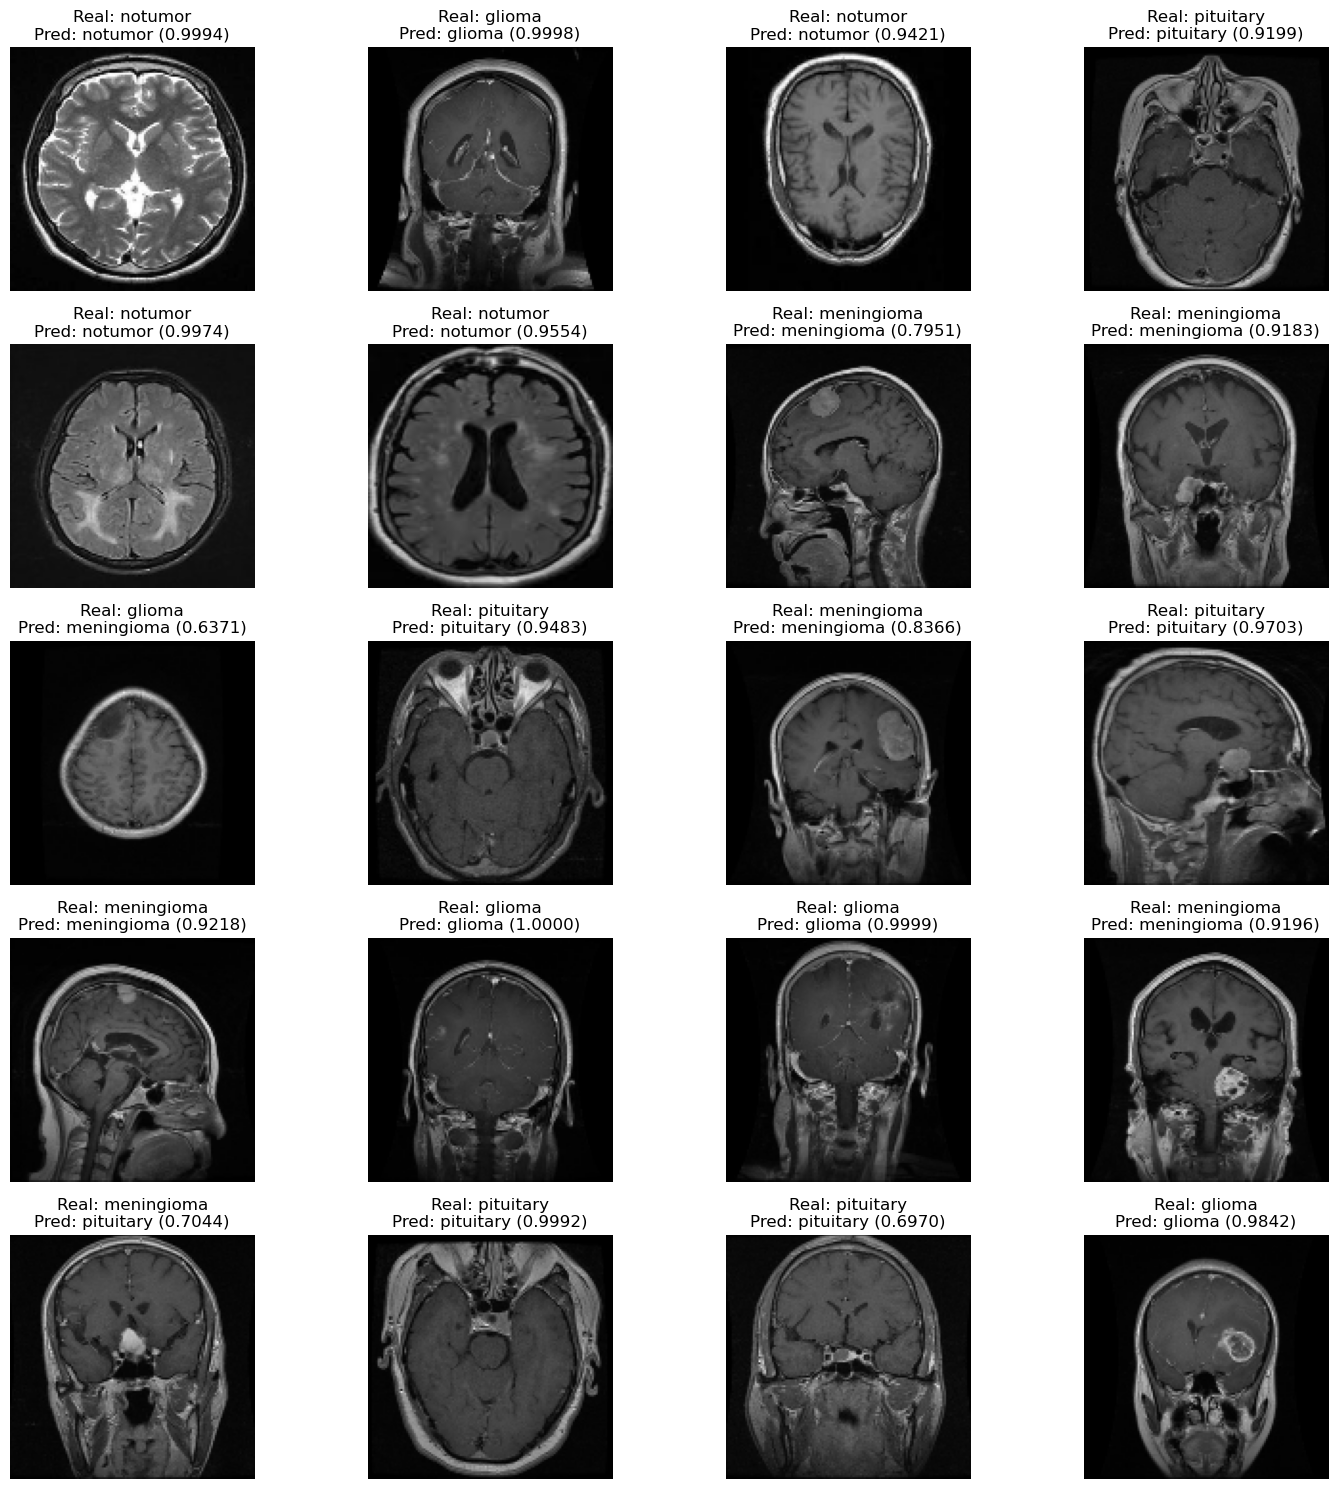

In [63]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input


# ÌÅ¥ÎûòÏä§ Ïù¥Î¶Ñ ÏßÄÏ†ï
class_names =['glioma', 'meningioma', 'notumor', 'pituitary']

# ÏÑ†ÌÉùÌï† Ïù¥ÎØ∏ÏßÄÏùò ÏãúÏûë Ïù∏Îç±Ïä§ÏôÄ ÎÅù Ïù∏Îç±Ïä§ ÏßÄÏ†ï
start_index = 200
end_index = 220

# ÌñâÍ≥º Ïó¥Ïùò Í∞úÏàò ÏßÄÏ†ï
num_rows = (end_index - start_index + 3) // 4  # +3 ensures rounding up
num_cols = 4

# ÏÑúÎ∏åÌîåÎ°Ø ÏÑ§Ï†ï
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))

# ÏãúÏûëÎ∂ÄÌÑ∞ ÎÅù Ïù∏Îç±Ïä§ÍπåÏßÄÏùò Ïù¥ÎØ∏ÏßÄÎì§ÏùÑ Ï≤òÎ¶¨
for idx, i in enumerate(range(start_index, end_index)):
    # Ïù¥ÎØ∏ÏßÄ ÌååÏùº Í≤ΩÎ°ú ÏÑ†ÌÉù
    selected_file_path = train_file_paths[i]

    # Ïù¥ÎØ∏ÏßÄ Î°úÎìú Î∞è Ï†ÑÏ≤òÎ¶¨
    image = cv2.cvtColor(cv2.imread(selected_file_path), cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (128, 128))
    processed_image = vgg16_preprocess_input(image.copy())

    # Î™®Îç∏ ÏòàÏ∏°
    predicted_probabilities = model.predict(np.expand_dims(processed_image, axis=0))

    # ÏòàÏ∏°Îêú ÌÅ¥ÎûòÏä§ Î∞è ÌôïÎ•† Ï∂úÎ†•
    predicted_class_index = np.argmax(predicted_probabilities)
    predicted_class_name = class_names[predicted_class_index]
    predicted_probability = predicted_probabilities[0][predicted_class_index]

    # Ïã§Ï†ú ÌÅ¥ÎûòÏä§ Ï†ïÎ≥¥ Í∞ÄÏ†∏Ïò§Í∏∞
    real_class_index = np.where(train_targets[i])[0][0]  # True Í∞íÏùò Ïù∏Îç±Ïä§ Í∞ÄÏ†∏Ïò§Í∏∞
    real_class_name = class_names[real_class_index]

    # ÏÑúÎ∏åÌîåÎ°ØÏóê Ïù¥ÎØ∏ÏßÄÏôÄ ÌÖçÏä§Ìä∏ Ï∂úÎ†•
    ax = axs[idx // num_cols, idx % num_cols]
    ax.imshow(image)
    ax.set_title(f"Real: {real_class_name}\nPred: {predicted_class_name} ({predicted_probability:.4f})")
    ax.axis('off')

# ÎÇ®ÏùÄ ÏÑúÎ∏åÌîåÎ°ØÏùÑ ÎπÑÌôúÏÑ±Ìôî
for j in range(idx + 1, num_rows * num_cols):
    axs[j // num_cols, j % num_cols].axis('off')

plt.tight_layout()
plt.show()